# Evaluacion EEGSA - Guatemala

**Generar la prediccion**

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from  tqdm.notebook import  tqdm
%config IPCompleter.use_jedi = False
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from itertools import groupby
warnings.filterwarnings('ignore')
import sys
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.base import ClassifierMixin
import joblib
import os
import sys
import time
import tensorflow as tf

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.5f}'.format #evita que muestre notacion cientifica
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from src.preprocessing.preprocessing  import data_wrangling, build_feature_engeniering_pipeline
from src.modeling.simple_models import ChangeTrendPercentajeIdentifierWide,ConstantConsumptionClassifierWide

In [6]:
from src.conf.config  import Config

## Config

In [13]:
Config.init_config()

In [14]:
DATA_PATH = Config.get('workspace').get('data_path')
MODEL_PATH = Config.get('workspace').get('model_path')
periodo = Config.get('model').get('periodo')
cols_derivadas = pd.read_csv(f'{MODEL_PATH}features_by_const_boruta2_{periodo}.csv')['0'].tolist()
cols_consumo = [f'{i}_anterior' for i in range(periodo, 0, -1)]
cols_uc = Config.get('model').get('cols_uc')
tsfel_names_path = f'{MODEL_PATH}/'+Config.get('model').get('tsfel_names_path')
BATCH_SIZE = Config.get('model').get('hip_NN').get('batch_size')
cols_for_model = cols_uc+cols_consumo+cols_derivadas
cols_comb_model = ['prob_cb','prob_lgbm','prob_ffn','prob_lstmffn','fraud_constante','fraud_trend']
hip_trend = Config.get('model').get('hip_trend') 
hip_const = Config.get('model').get('hip_const')

name_model_fraud_lgbm = f'{MODEL_PATH}/'+Config.get('model').get('lgbm_model_name')
name_model_fraud_cat = f'{MODEL_PATH}/'+Config.get('model').get('cat_model_name')
name_model_fraud_nn = f'{MODEL_PATH}/'+Config.get('model').get('nn_model_name')
name_model_fraud_lstmnn = f'{MODEL_PATH}/'+Config.get('model').get('lstmnn_model_name')
name_pipe_features = f'{MODEL_PATH}/'+Config.get('model').get('pipe_feat_name')
name_pipe_spent = f'{MODEL_PATH}/'+Config.get('model').get('pipe_spent_name')
name_model_fraud_comb  = f'{MODEL_PATH}/'+Config.get('model').get('comb_model_name')

filename = Config.get('evaluacion').get('evaluation_data')
mes_ultimo_consumo = Config.get('evaluacion').get('mes_ultimo_consumo')
th_critico = Config.get('evaluacion').get('th_critico') #0.86
th_warning = Config.get('evaluacion').get('th_warning') #0.7
cols_final = ['uc'] + cols_consumo + ['codigo_postal','alerta','prob_final']
name_resultado_normales = f'{MODEL_PATH}/normales_prediccion_{mes_ultimo_consumo}.csv'
name_resultado_anomalias = f'{MODEL_PATH}/anomalias_prediccion_{mes_ultimo_consumo}.csv'

## Funciones

In [15]:
def cb_predict_proba(X):
    model = joblib.load(name_model_fraud_lgbm)
    proba = model.predict_proba(X)
    return proba[:,1]

def lgbm_predict_proba(X):
    model = joblib.load(name_model_fraud_cat)
    proba = model.predict_proba(X)
    return proba[:,1]

def fnn_predict_proba(df):
    features_names = cols_uc+cols_derivadas
    spents_names = cols_consumo
    pipe_features = joblib.load(name_pipe_features)
    pipe_spent = joblib.load(name_pipe_spent)
    model = tf.keras.models.load_model(name_model_fraud_nn)
    X_features = pipe_features.transform(df[features_names])
    X_spents = pipe_spent.transform(df[spents_names])
    X = np.concatenate([X_features,X_spents],axis=1)
    pred_rnn = model.predict(X, batch_size=BATCH_SIZE)
    return pred_rnn[:,0]

def lstm_fnn_predict_proba(df):
    features_names = cols_uc+cols_derivadas
    spents_names = cols_consumo
    pipe_features = joblib.load(name_pipe_features)
    pipe_spent = joblib.load(name_pipe_spent)
    model = tf.keras.models.load_model(name_model_fraud_lstmnn)
    X_features = pipe_features.transform(df[features_names])
    X_spents = pipe_spent.transform(df[spents_names])
    X_spents = X_spents.reshape((X_spents.shape[0],periodo,1))
    pred = model.predict([X_spents, X_features],batch_size=BATCH_SIZE)
    return pred[:,0]

def combinado_model_predict_proba(df):
    comb_model = joblib.load(name_model_fraud_comb)
    return comb_model.predict_proba(df[cols_comb_model])[:,1]
    
def load_datasets():
    df = pd.read_parquet(DATA_PATH+filename)
    return df

def preprocess_datasets(df):
    ## Esto deberia estar en el ETL
    df.rename(columns={'id_usuario':'uc'}, inplace=True)
    df.rename(columns={'id':'index'}, inplace=True)
    # Solo nos quedamos con aquellos usuarios que tienen al menos 10 meses de tiempo de conexion 
    # No esten dados de baja y tengan al menos 6 consumos validos
    ultimo_mes_consumo = pd.to_datetime(mes_ultimo_consumo)
    mes_evaluacion = ultimo_mes_consumo + pd.DateOffset(months=1)
    df['cant_meses_conectado'] = ((mes_evaluacion - df.fecha_de_alta)/np.timedelta64(1, 'M'))
    df['is_baja'] = df.fecha_de_baja<mes_evaluacion
    df = df[(df.is_baja==False)&(df.cant_null<=6)&(df.cant_meses_conectado>=10)]
    # limpieza y calculo de variables
    df = data_wrangling(df,periodo)
    pipe_feature_eng = build_feature_engeniering_pipeline(tsfel_names_path,num_periodos= periodo)
    df = pipe_feature_eng.fit_transform(df, None)
    return df

## Load Data

In [18]:
start_time = time.time()

In [25]:
%%time
df = load_datasets()
df.shape

CPU times: user 3.14 s, sys: 2.48 s, total: 5.62 s
Wall time: 2.43 s


(1322465, 38)

In [28]:
df['id'] = list(range(len(df)))

In [29]:
df = df.sample(10000)

## Preproceso -  Data

In [32]:
%%time
df = preprocess_datasets(df)

self.read False
ENTRO PARA CREAR JSON
*** Feature extraction started ***



*** Feature extraction finished ***
df_result index: (10000,)
df_tsfel (10000, 21)
CPU times: user 46.9 s, sys: 4.58 s, total: 51.5 s
Wall time: 48 s


In [33]:
df.shape

(10000, 88)

## Prediccion de Modelos

In [39]:
### Modelo Trend change
trend_perc_model = ChangeTrendPercentajeIdentifierWide(**hip_trend)
pred_tc = trend_perc_model.predict(df)
df['fraud_trend'] = pred_tc.is_fraud_trend_perc
### Modelo constante
const_model = ConstantConsumptionClassifierWide(**hip_const)
pred_cm = const_model.predict(df[cols_consumo])
df['fraud_constante'] = pred_cm
### Modelos supervisados
df['prob_cb'] =  cb_predict_proba(df[cols_for_model])
df['prob_lgbm'] = lgbm_predict_proba(df[cols_for_model])
df['prob_ffn'] = fnn_predict_proba(df[cols_for_model])
df['prob_lstmffn'] = lstm_fnn_predict_proba(df[cols_for_model])
### Modelo combinado
df['prob_final'] = combinado_model_predict_proba(df)

2022-12-11 20:56:15.044137: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-11 20:56:15.044178: E tensorflow/stream_executor/cuda/cuda_driver.cc:351] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-11 20:56:15.044283: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (49434f55fd6e): /proc/driver/nvidia/version does not exist
2022-12-11 20:56:15.044475: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-12-11 20:56:15.070098: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400010000 Hz
2022-12-11 20:56:15.071483: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5581d1f2fc20 initialized for platform Host (this does not guarantee tha

## Post - Proceso - Resultado

In [40]:
df['alerta'] = 'sin_alerta'
df.loc[(df.alerta=='sin_alerta')&(df.cant_ceros_12==12),'alerta'] = 'consumo_0'
msk_critico = df.prob_final>=th_critico 
df.loc[(df.alerta=='sin_alerta')&(msk_critico),'alerta'] = 'critico'
msk_warning = df.prob_final>=th_warning
df.loc[(df.alerta=='sin_alerta')&(msk_warning),'alerta'] = 'warning'
df.loc[(df.alerta=='sin_alerta')&(pred_tc.is_fraud_trend_perc==1),'alerta'] = 'cambio_neg_consumo'
df.loc[(df.alerta=='sin_alerta')&(pred_cm==1),'alerta'] = 'consumo_constante'
df.loc[(df.alerta=='sin_alerta'),'alerta'] = 'normal'

In [41]:
df[(df.alerta=='normal')][cols_final].to_csv(name_resultado_normales,index=False)
df[(df.alerta!='normal')][cols_final].to_csv(name_resultado_anomalias,index=False)

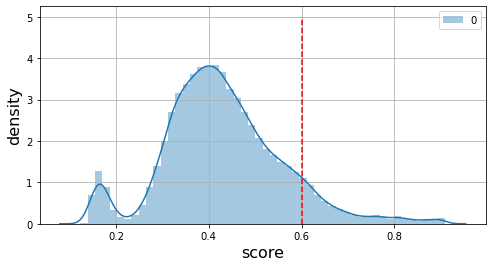

In [51]:
plt.figure(figsize=(8,4))
sns.distplot(df.prob_final, label='0')
plt.vlines(0.6, ymin=0, ymax=5, color='red', linestyles='dashed')
plt.xlabel('score', fontsize=16)
plt.ylabel('density', fontsize=16)
plt.legend()
plt.grid()

In [ ]:
print("Fin")
print("--- %s seconds ---" % (time.time() - start_time))